# AI Christmas Hackathon

The goal is to synthesize the given dataset using a vanilla VAE architecture using dense layers and TensorFlow2.


- [Kaggle website](https://www.kaggle.com/datasets/smartfactoryowl/currentpred)

- [Further information](https://smartfactory-owl.de/eventer/ai-christmas-hackathon/)

- [YouTube video](https://www.youtube.com/watch?v=JUEyLh2f1AM)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import plotly
# import plotly.express as px
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\arjun\anaconda3\envs\tensorflow-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080 Laptop GPU


In [5]:
data = pd.read_csv("training.csv", low_memory = False, sep = ";")

In [6]:
data.shape

(3456000, 8)

In [7]:
# data.info()
data.dtypes

DateTime                object
LiftWorkingPosition       bool
Current                float64
Speed                  float64
YAxisCurrent           float64
YAxisSpeed             float64
Temperature            float64
Rms                    float64
dtype: object

In [8]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.sort_values(by = 'DateTime', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [9]:
data.dtypes

DateTime               datetime64[ns, UTC]
LiftWorkingPosition                   bool
Current                            float64
Speed                              float64
YAxisCurrent                       float64
YAxisSpeed                         float64
Temperature                        float64
Rms                                float64
dtype: object

In [10]:
data.isna().values.any()

True

In [11]:
data.isna().sum()

DateTime                0
LiftWorkingPosition     0
Current                96
Speed                  96
YAxisCurrent           96
YAxisSpeed             96
Temperature             0
Rms                     0
dtype: int64

In [12]:
np.all(data[data['Current'].isna()].index == data[data['Speed'].isna()].index)

True

In [13]:
np.all(data[data['Speed'].isna()].index == data[data['YAxisCurrent'].isna()].index)

True

In [14]:
np.all(data[data['Speed'].isna()].index == data[data['YAxisSpeed'].isna()].index)

True

In [15]:
# Data Imputation- impute missing values with previous values-
data.fillna(method ='pad', inplace = True)

In [16]:
# Sanity check-
data.isna().values.any()

False

In [17]:
data.head()

,DateTime,LiftWorkingPosition,Current,Speed,YAxisCurrent,YAxisSpeed,Temperature,Rms
0,2021-10-04 00:00:00+00:00,False,6.8,18000.0,0.0,0.010029,34.180720,11.0620
1,2021-10-04 00:00:00.100000+00:00,False,6.8,18000.0,0.6,0.004324,34.214291,10.9507
2,2021-10-04 00:00:00.200000+00:00,False,6.8,18000.0,0.5,0.004105,34.247862,10.8394
3,2021-10-04 00:00:00.300000+00:00,False,6.8,18000.0,0.4,0.006934,34.281433,10.7281
4,2021-10-04 00:00:00.400000+00:00,False,6.8,18000.0,0.4,0.006521,34.315004,10.6168


In [18]:
data['DateTime'].min(), data['DateTime'].max()

(Timestamp('2021-10-04 00:00:00+0000', tz='UTC'),
 Timestamp('2021-10-07 23:59:59.900000+0000', tz='UTC'))

### Visualizations

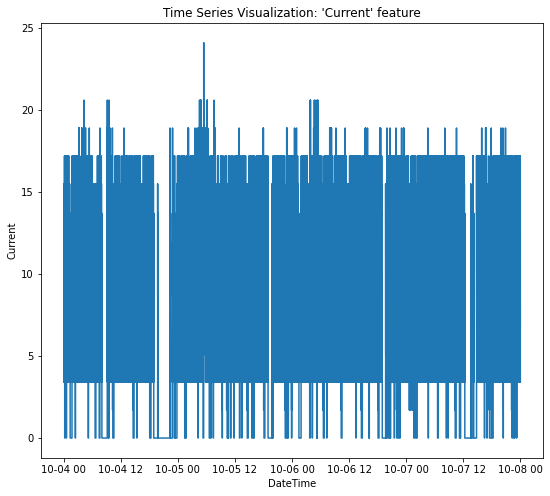

In [22]:
plt.figure(figsize = (9, 8))
plt.plot(data['DateTime'], data['Current'])
plt.xlabel("DateTime")
plt.ylabel("Current")
plt.title("Time Series Visualization: 'Current' feature")
plt.show()

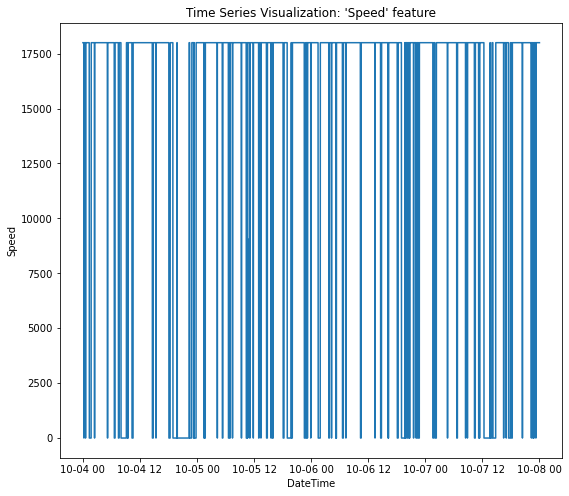

In [23]:
plt.figure(figsize = (9, 8))
plt.plot(data['DateTime'], data['Speed'])
plt.xlabel("DateTime")
plt.ylabel("Speed")
plt.title("Time Series Visualization: 'Speed' feature")
plt.show()

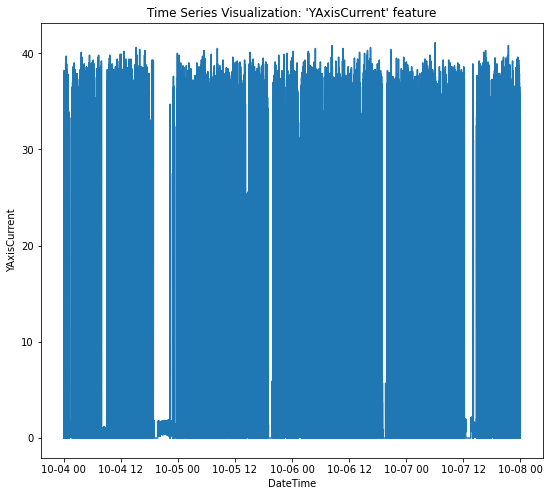

In [24]:
plt.figure(figsize = (9, 8))
plt.plot(data['DateTime'], data['YAxisSpeed'])
plt.xlabel("DateTime")
plt.ylabel("YAxisSpeed")
plt.title("Time Series Visualization: 'YAxisSpeed' feature")
plt.show()

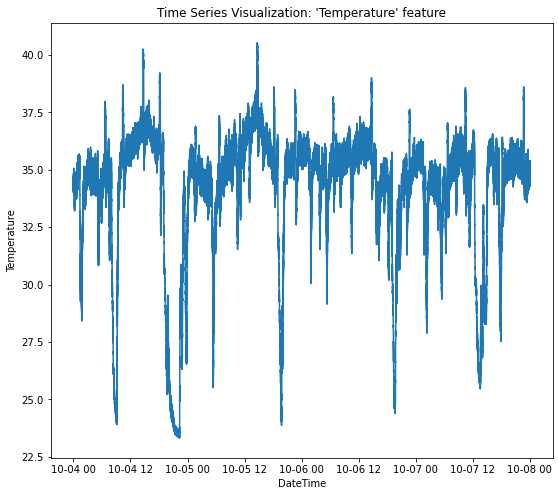

In [25]:
plt.figure(figsize = (9, 8))
plt.plot(data['DateTime'], data['Temperature'])
plt.xlabel("DateTime")
plt.ylabel("Temperature")
plt.title("Time Series Visualization: 'Temperature' feature")
plt.show()

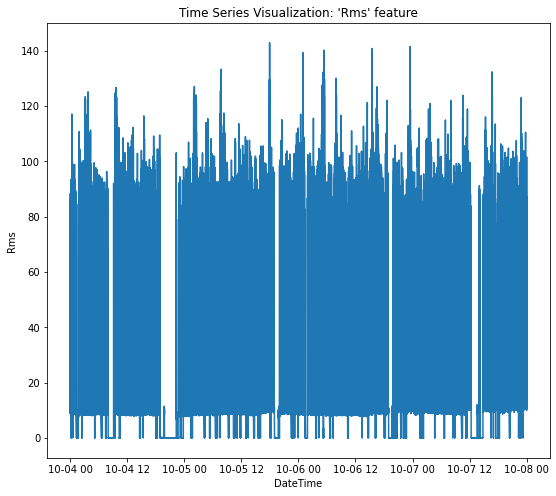

In [26]:
plt.figure(figsize = (9, 8))
plt.plot(data['DateTime'], data['Rms'])
plt.xlabel("DateTime")
plt.ylabel("Rms")
plt.title("Time Series Visualization: 'Rms' feature")
plt.show()

In [27]:
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins (rule of thumb) = {num_bins}")

number of bins (rule of thumb) = 1860


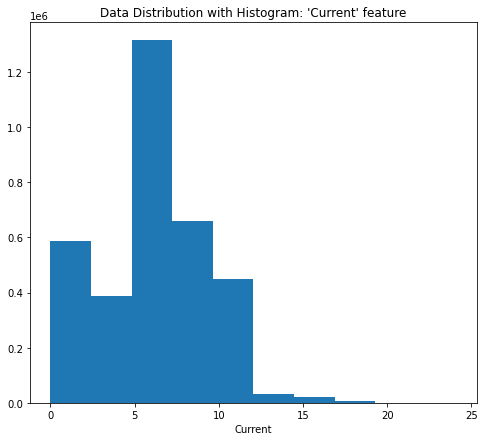

In [28]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Current'])
plt.xlabel("Current")
plt.title("Data Distribution with Histogram: 'Current' feature")
plt.show()

In [39]:
data[data['Current'] <= 0].shape

(584973, 8)

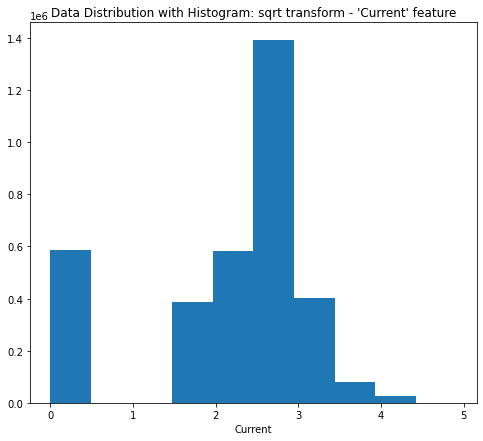

In [40]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.sqrt(data['Current']))
plt.xlabel("Current")
plt.title("Data Distribution with Histogram: sqrt transform - 'Current' feature")
plt.show()

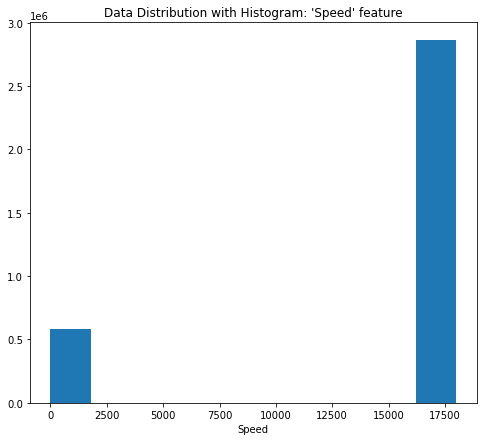

In [29]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Speed'])
plt.xlabel("Speed")
plt.title("Data Distribution with Histogram: 'Speed' feature")
plt.show()

In [35]:
# Print top 20 most common values-
data['Speed'].value_counts().iloc[:20]

18000.00000    2860351
0.00000         585036
2147.82700          15
9947.02100          15
17147.46000         15
13847.17000         14
12071.78000         14
971.19140           14
6047.97400          14
12886.96000         14
1571.04500          14
11147.83000         14
7247.68100          13
2747.68100          13
7991.45500          13
10835.82000         13
5267.94400          13
47.24121            13
3947.38800          13
10391.97000         13
Name: Speed, dtype: int64

In [42]:
data[data['Speed'] == 0].shape

(585036, 8)

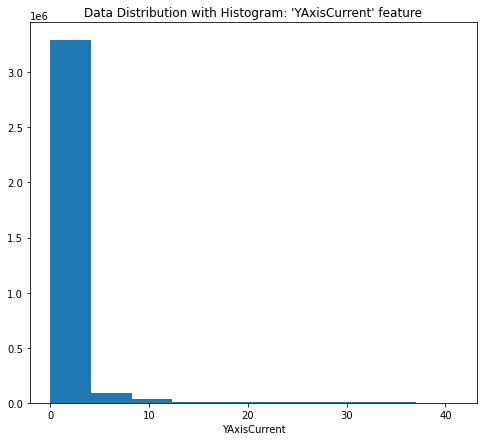

In [51]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['YAxisCurrent'])
plt.xlabel("YAxisCurrent")
plt.title("Data Distribution with Histogram: 'YAxisCurrent' feature")
plt.show()

In [48]:
data[data['YAxisCurrent'] <= 0].shape

(191228, 8)

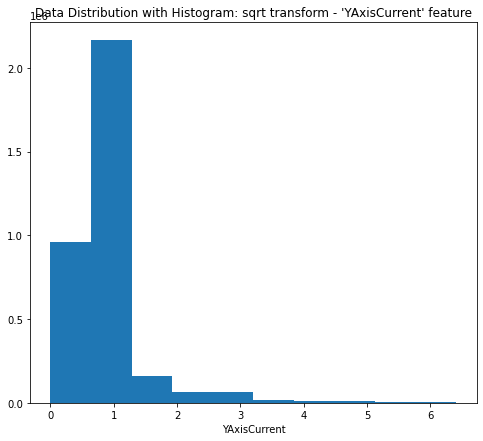

In [50]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.sqrt(data['YAxisCurrent']))
plt.xlabel("YAxisCurrent")
plt.title("Data Distribution with Histogram: sqrt transform - 'YAxisCurrent' feature")
plt.show()

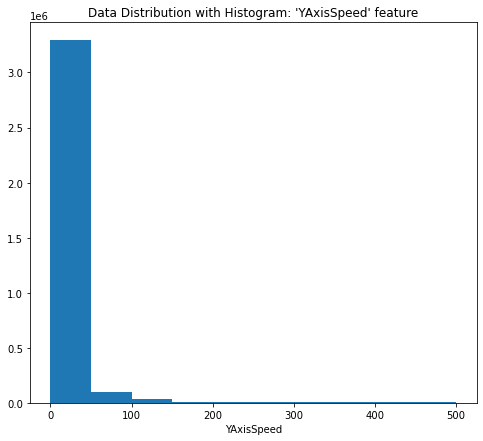

In [52]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['YAxisSpeed'])
plt.xlabel("YAxisSpeed")
plt.title("Data Distribution with Histogram: 'YAxisSpeed' feature")
plt.show()

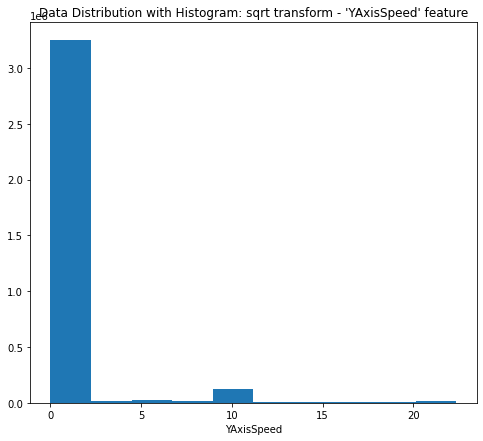

In [53]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.sqrt(data['YAxisSpeed']))
plt.xlabel("YAxisSpeed")
plt.title("Data Distribution with Histogram: sqrt transform - 'YAxisSpeed' feature")
plt.show()

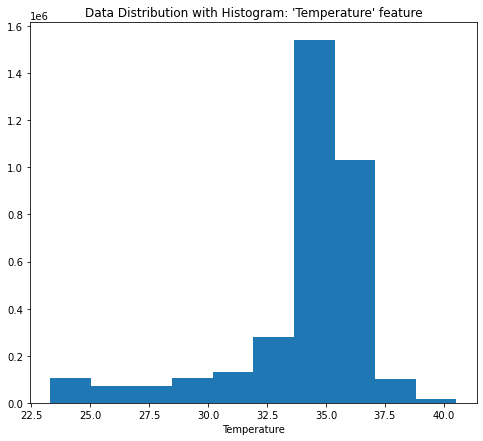

In [54]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Temperature'])
plt.xlabel("Temperature")
plt.title("Data Distribution with Histogram: 'Temperature' feature")
plt.show()

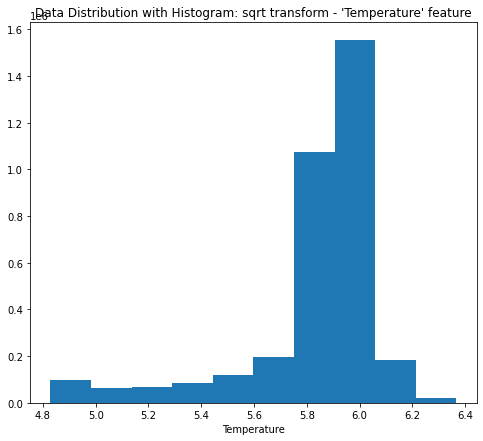

In [55]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.sqrt(data['Temperature']))
plt.xlabel("Temperature")
plt.title("Data Distribution with Histogram: sqrt transform - 'Temperature' feature")
plt.show()

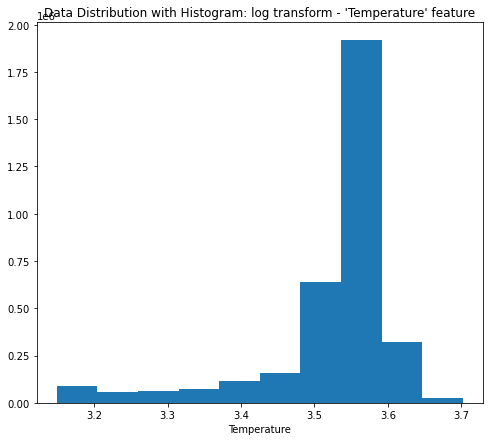

In [56]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.log(data['Temperature']))
plt.xlabel("Temperature")
plt.title("Data Distribution with Histogram: log transform - 'Temperature' feature")
plt.show()

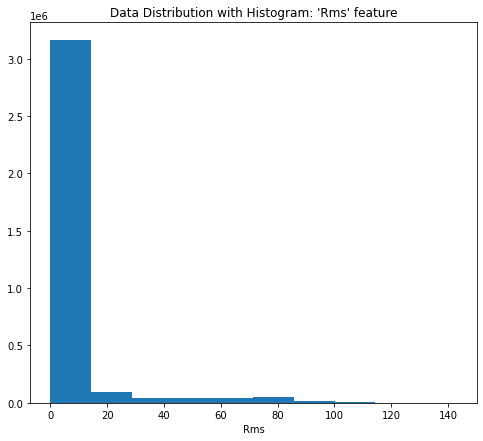

In [57]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Rms'])
plt.xlabel("Rms")
plt.title("Data Distribution with Histogram: 'Rms' feature")
plt.show()

In [58]:
data[data['Rms'] <= 0].shape

(0, 8)

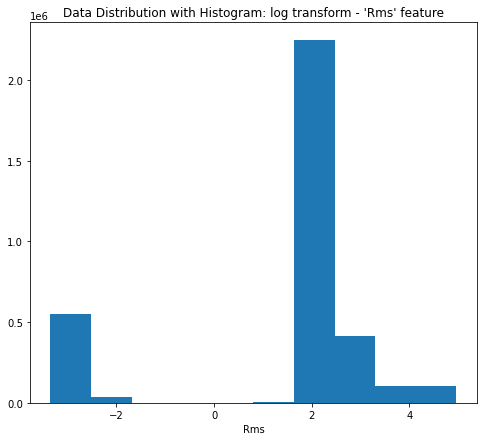

In [59]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.log(data['Rms']))
plt.xlabel("Rms")
plt.title("Data Distribution with Histogram: log transform - 'Rms' feature")
plt.show()

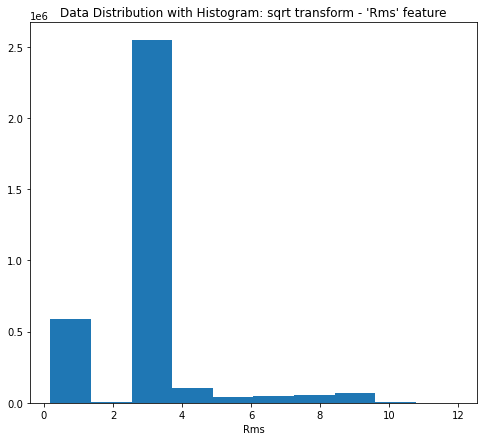

In [60]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.sqrt(data['Rms']))
plt.xlabel("Rms")
plt.title("Data Distribution with Histogram: sqrt transform - 'Rms' feature")
plt.show()

In [19]:
# Apply transformations to different features-
data['Current'] = np.sqrt(data['Current'])
data['YAxisCurrent'] = np.sqrt(data['YAxisCurrent'])
data['YAxisSpeed'] = np.sqrt(data['YAxisSpeed'])
data['Temperature'] = np.sqrt(data['Temperature'])
data['Rms'] = np.sqrt(data['Rms'])

In [20]:
# Sanity check-
data.head()

,DateTime,LiftWorkingPosition,Current,Speed,YAxisCurrent,YAxisSpeed,Temperature,Rms
0,2021-10-04 00:00:00+00:00,False,2.607681,18000.0,0.000000,0.100143,5.846428,3.325959
1,2021-10-04 00:00:00.100000+00:00,False,2.607681,18000.0,0.774597,0.065757,5.849298,3.309184
2,2021-10-04 00:00:00.200000+00:00,False,2.607681,18000.0,0.707107,0.064068,5.852167,3.292324
3,2021-10-04 00:00:00.300000+00:00,False,2.607681,18000.0,0.632456,0.083269,5.855035,3.275378
4,2021-10-04 00:00:00.400000+00:00,False,2.607681,18000.0,0.632456,0.080753,5.857901,3.258343


In [21]:
# Convert to float32 type-
data = data.iloc[:, 1:].astype('float32')

In [22]:
data.shape

(3456000, 7)

In [23]:
# Split data into training and validation datasets. Ratio is
# 90:10-
len(data[: int(len(data) * 0.9)]), len(data[int(len(data) * 0.9): ])

(3110400, 345600)

In [24]:
# Sanity check-
len(data[: int(len(data) * 0.9)]) + len(data[int(len(data) * 0.9): ]) == len(data)

True

In [25]:
# Create train and test sets-
train_data = data[: int(len(data) * 0.9)]
test_data = data[int(len(data) * 0.9): ]

# Sanity check-
train_data.shape, test_data.shape

((3110400, 7), (345600, 7))

In [26]:
# Scale processed dataset-
mm_scaler = MinMaxScaler(feature_range = (-1, 1))
std_scaler = StandardScaler()

In [27]:
train_data = mm_scaler.fit_transform(train_data)
test_data = mm_scaler.transform(test_data)

In [28]:
# Sanity check-
train_data.shape, test_data.shape

((3110400, 7), (345600, 7))

In [29]:
# Sanity check-
print(f"min-max values for train dataset are: ")
for col in range(train_data.shape[1]):
    print(f"{col}; min = {train_data[:, col].min():.4f} &"
          f" max = {train_data[:, col].max():.4f}")

min-max values for train dataset are: 
0; min = -1.0000 & max = 1.0000
1; min = -1.0000 & max = 1.0000
2; min = -1.0000 & max = 1.0000
3; min = -1.0000 & max = 1.0000
4; min = -1.0000 & max = 1.0000
5; min = -1.0000 & max = 1.0000
6; min = -1.0000 & max = 1.0000


In [30]:
# Sanity check-
print(f"min-max values for test dataset are: ")
for col in range(test_data.shape[1]):
    print(f"{col}; min = {test_data[:, col].min():.4f} &"
          f" max = {test_data[:, col].max():.4f}")

min-max values for test dataset are: 
0; min = -1.0000 & max = 1.0000
1; min = -1.0000 & max = 0.7711
2; min = -1.0000 & max = 1.0000
3; min = -1.0000 & max = 0.9927
4; min = -1.0000 & max = 0.9996
5; min = -0.4563 & max = 0.8012
6; min = -0.9995 & max = 0.9237


In [32]:
# Specify hyper-parameters for VAE training-
num_epochs = 100
batch_size = 1024

In [33]:
# number of steps/iterations in train and test data-
len(train_data) / batch_size, len(test_data) / batch_size

(3037.5, 337.5)

In [34]:
# Create TF train and test dataset to iterate over-
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(batch_size = batch_size, drop_remainder = True)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(batch_size = batch_size, drop_remainder = True)

In [35]:
# Sanity check-
x = next(iter(train_dataset))
x.shape

TensorShape([1024, 7])

In [36]:
del x, train_data, test_data

In [37]:
class VAE_Encoder(Model):
    def __init__(self, latent_space = 5):
        super(VAE_Encoder, self).__init__()
        self.latent_space = latent_space
        
        self.dense1 = Dense(units = 100, activation = None)
        self.bn1 = BatchNormalization()
        self.dense2 = Dense(units = 50, activation = None)
        self.bn2 = BatchNormalization()
        self.dense3 = Dense(units = 20, activation = None)
        self.bn3 = BatchNormalization()
        self.dense3 = Dense(units = self.latent_space, activation = None)
        self.bn3 = BatchNormalization()
    
    
    def call(self, x):
        x = tf.nn.relu(self.bn1(self.dense1(x)))
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        x = tf.nn.relu(self.bn3(self.dense3(x)))
        return x
        
        

In [38]:
class VAE_Decoder(Model):
    def __init__(self, latent_space = 5):
        super(VAE_Decoder, self).__init__()
        self.latent_space = latent_space
        
        self.dense1 = Dense(units = self.latent_space, activation = None)
        self.bn1 = BatchNormalization()
        self.dense2 = Dense(units = 20, activation = None)
        self.bn2 = BatchNormalization()
        self.dense3 = Dense(units = 50, activation = None)
        self.bn3 = BatchNormalization()
        self.dense4 = Dense(units = 100, activation = None)
        self.bn4 = BatchNormalization()
        self.dense5 = Dense(units = 7, activation = None)
        
    
    def call(self, x):
        x = tf.nn.relu(self.bn1(self.dense1(x)))
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        x = tf.nn.relu(self.bn3(self.dense3(x)))
        x = tf.nn.relu(self.bn4(self.dense4(x)))
        x = self.dense5(x)
        return x
        
        

In [39]:
class VAE(Model):
    def __init__(self, latent_space = 7):
        super(VAE, self).__init__()
        self.latent_space = latent_space
        
        self.encoder = VAE_Encoder(latent_space = self.latent_space)
        self.decoder = VAE_Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)
    
    
    def call(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x = tf.nn.tanh(self.decoder(z))
        return x, mu, log_var
    
    

In [40]:
model = VAE(latent_space = 7)

In [41]:
x = next(iter(train_dataset))

In [42]:
x_recon, mu, log_var = model(x)

In [43]:
x_recon.shape, x.shape

(TensorShape([1024, 7]), TensorShape([1024, 7]))

In [44]:
mu.shape, log_var.shape

(TensorShape([1024, 7]), TensorShape([1024, 7]))

In [45]:
del x, x_recon, mu, log_var

In [46]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae__encoder (VAE_Encoder)  multiple                  6835      
                                                                 
 vae__decoder (VAE_Decoder)  multiple                  7781      
                                                                 
 dense_9 (Dense)             multiple                  56        
                                                                 
 dense_10 (Dense)            multiple                  56        
                                                                 
Total params: 14,728
Trainable params: 14,060
Non-trainable params: 668
_________________________________________________________________


In [47]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [48]:
def compute_total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    
    # Compute KL-divergence loss:
    
    # Sum over latent dimensions-
    kl_loss = -0.5 * tf.math.reduce_sum(
        input_tensor = (1 + log_var - tf.square(mu) - tf.exp(log_var)),
        axis = 1
    )
    # Omitting 'axis' will give bad results as it will sum over everything!
    # First, sum over the latent dimensions and then average over the batches.
    
    # kl_loss.shape
    # TensorShape([64])
    
    batchsize = len(kl_loss)
    
    # Compute average KL-divergence over batch size-
    kl_loss = tf.math.reduce_mean(input_tensor = kl_loss)
    
    
    # Compute Reconstruction loss:
    
    # Sum over all pixels-
    '''
    1. Reshape recon_loss so that it is batchsize and a 1-D vector. So, instead
    of having a (multi-dim) tensor, it is now a 2-D matrix/table.
    
    2. Then, sum over the pixels. This is equivalent to summing over the latent
    dimensions for 'kl_div' above. We are summing first the squared error over the
    channels/pixels and then average over the batch dimensions below.
    '''
    recon_loss = tf.square(tf.reshape(tensor = data, shape = (batchsize, -1)) - tf.reshape(tensor = data_recon, shape = (batchsize, -1)))
    
    # recon_loss.shape
    # TensorShape([64, 784])
    
    recon_loss = tf.math.reduce_sum(recon_loss, axis = 1)
    
    # recon_loss.shape
    # TensorShape([64, 784])
    
    recon_loss = tf.math.reduce_mean(recon_loss)
    
    final_loss = (alpha * recon_loss) + (beta * kl_loss)
    
    return final_loss, recon_loss, kl_loss
    

In [ ]:
'''
# Sanity check-
total_loss, recon_loss, kl_loss = compute_total_loss(
    data = x, data_recon = x_recon,
    mu = mu, log_var = log_var,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
print(f"Total loss = {total_loss:.4f}, Reconstruction loss = {recon_loss:.4f} &"
      f" KL-div loss = {kl_loss:.4f}")
'''

In [49]:
@tf.function
def train_one_step(model, optimizer, data, alpha, beta):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var = model(data)
 
        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_total_loss(
            data = data, data_recon = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [50]:
@tf.function
def test_step(model, optimizer, data, alpha, beta):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_total_loss(
            data = data, data_recon = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha, beta = beta
        )
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
# Sanity check-
total_train_loss, recon_train_loss, kl_train_loss = train_one_step(
    model = model, optimizer = optimizer,
    data = x, alpha = 1,
    beta = 1
)
'''

In [ ]:
'''
# Sanity check-
total_val_loss, recon_val_loss, kl_val_loss = test_step(
    model = model, optimizer = optimizer,
    data = x, alpha = 1,
    beta = 1
)
'''

In [ ]:
'''
print(f"Total train loss = {total_train_loss:.4f}, total val loss = {total_val_loss:.4f}"
      f", recon_train_loss = {recon_train_loss:.4f}, recon_val_loss = {recon_val_loss:.4f}"
      f", kl_train_loss = {kl_train_loss:.4f} & kl_val_loss = {kl_val_loss:.4f}")
'''

In [51]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 100 epochs


In [52]:
# Python3 dict to contain training metrics-
training_metrics = {}

In [53]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence
# trade-off-
alpha = 1
beta = 1

In [54]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000

In [55]:
for epoch in range(1, num_epochs + 1):
    
    # Epoch train & validation losses-
    train_loss = 0.0
    val_loss = 0.0
    train_recon_loss = 0.0
    val_recon_loss = 0.0
    train_kl_loss = 0.0
    val_kl_loss = 0.0
    
    for data in train_dataset:
        total_train_loss, recon_train_loss, kl_train_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha,
            beta = beta
        )
        
        train_loss += total_train_loss.numpy()
        train_recon_loss += recon_train_loss.numpy()
        train_kl_loss += kl_train_loss.numpy()
        
    
    for test_data in test_dataset:
        total_val_loss, recon_val_loss, kl_val_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha,
            beta = beta
        )
        
        val_loss += total_val_loss.numpy()
        val_recon_loss += recon_val_loss.numpy()
        val_kl_loss += kl_val_loss.numpy()

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_recon_loss,
        'kl_loss': train_kl_loss, 'total_val_loss': val_loss,
        'recon_val_loss': val_recon_loss, 'val_kl_loss': val_kl_loss
        }
    

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_recon_loss:.4f}, train kl loss = {train_kl_loss:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f} &"
    f" val kl loss = {val_kl_loss:.4f}"
    )
    
    
    # Save 'best' model so far-
    if val_loss < best_val_loss:
        # Update for lowest val_loss so far-
        best_val_loss = val_loss
        
        print(f"\nSaving model with lowest Total validation loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation loss-
        model.save_weights("VAE_best_total_val_loss.h5", overwrite = True)


epoch = 1; total train loss = 3872.2718, train recon loss = 3865.0617, train kl loss = 7.2101; total val loss = 605.2078, val recon loss = 605.0947 & val kl loss = 0.1131

Saving model with lowest Total validation loss = 605.2078

epoch = 2; total train loss = 3665.7706, train recon loss = 3663.8265, train kl loss = 1.9441; total val loss = 488.1791, val recon loss = 488.1481 & val kl loss = 0.0310

Saving model with lowest Total validation loss = 488.1791

epoch = 3; total train loss = 3688.9555, train recon loss = 3687.5339, train kl loss = 1.4216; total val loss = 457.1424, val recon loss = 457.1046 & val kl loss = 0.0378

Saving model with lowest Total validation loss = 457.1424

epoch = 4; total train loss = 3695.8455, train recon loss = 3694.8577, train kl loss = 0.9879; total val loss = 455.7210, val recon loss = 455.6942 & val kl loss = 0.0269

Saving model with lowest Total validation loss = 455.7210

epoch = 5; total train loss = 3699.5152, train recon loss = 3698.9623, train

In [ ]:
# Save trained model-
# model.save_weights("VAE_last_epoch.h5", overwrite = True)

In [56]:
# Save training metrics-
with open("VAE_dataset_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

### Visualize training metrics

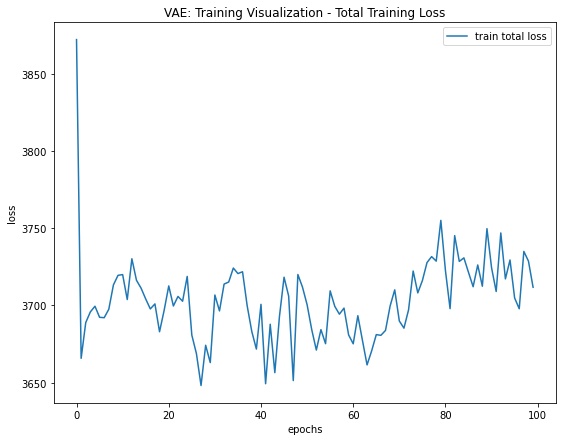

In [57]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

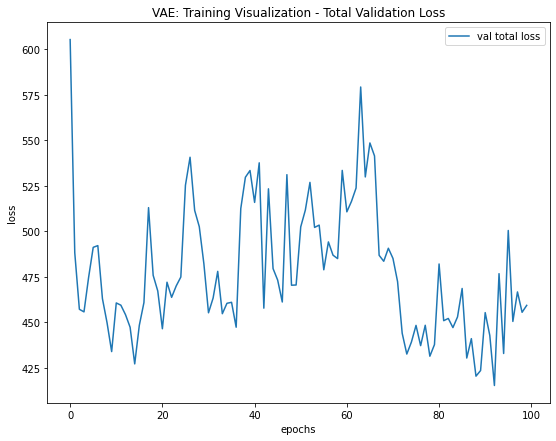

In [58]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_val_loss'] for e in training_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

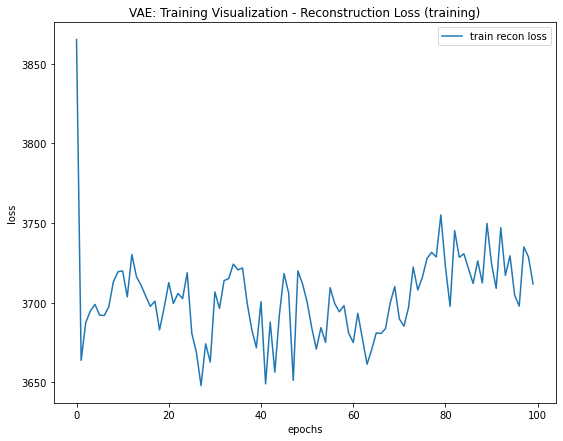

In [59]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

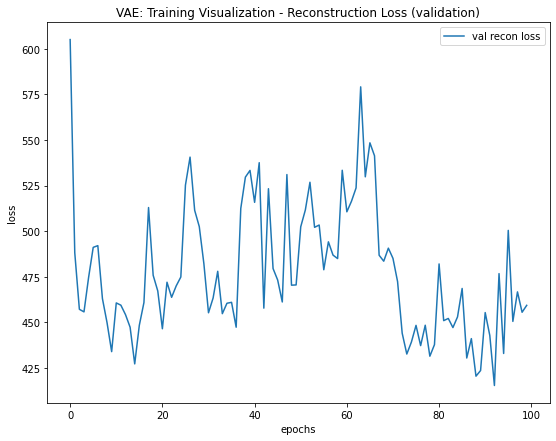

In [60]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_val_loss'] for e in training_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

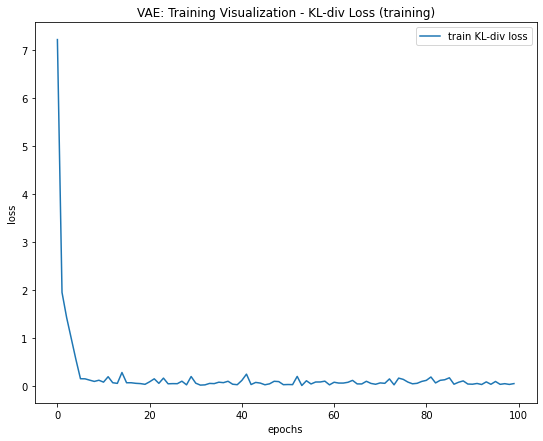

In [61]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

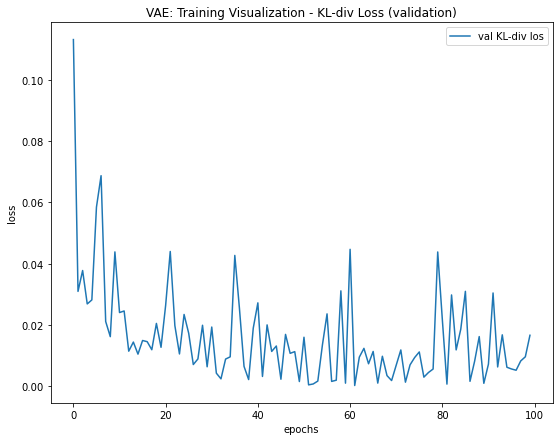

In [62]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['val_kl_loss'] for e in training_metrics.keys()], label = 'val KL-div los')
plt.legend(loc = 'best')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

In [63]:
del model

In [65]:
# Load 'best' trained parameters-
trained_model = VAE(latent_space = 7)

In [66]:
x = next(iter(test_dataset))

In [67]:
pred, mu, log_var = trained_model(x)

In [68]:
x.shape, pred.shape

(TensorShape([1024, 7]), TensorShape([1024, 7]))

In [69]:
mu.shape, log_var.shape

(TensorShape([1024, 7]), TensorShape([1024, 7]))

In [70]:
del x, pred, mu, log_var

In [71]:
trained_model.load_weights("VAE_best_total_val_loss.h5")

In [92]:
predictions = []
true_vals  = []

In [93]:
for x in test_dataset:
    pred, _, _ = trained_model(x)
    predictions.append(pred)
    true_vals.append(x)

In [ ]:
'''
for x in test_dataset:
    z = tf.random.normal(
        shape = (batch_size, 7), mean = 0.0,
        stddev = 1.0
    )
    pred = tf.nn.tanh(trained_model.decoder(z))
    predictions.append(pred)
    true_vals.append(x)
'''

In [94]:
predictions = np.vstack(predictions)
true_vals = np.vstack(true_vals)

In [ ]:
del z, pred, x

In [96]:
predictions.shape, true_vals.shape

((345088, 7), (345088, 7))

In [97]:
# Inverse scale values-
predictions = mm_scaler.inverse_transform(predictions)
true_vals = mm_scaler.inverse_transform(true_vals)

In [80]:
# LiftWorkingPosition 	Current 	Speed 	YAxisCurrent 	YAxisSpeed 	Temperature 	Rms

In [98]:
# Undo transformations to different features-
predictions[:, 1] = np.square(predictions[:, 1])
predictions[:, 3] = np.square(predictions[:, 3])
predictions[:, 4] = np.square(predictions[:, 4])
predictions[:, 5] = np.square(predictions[:, 5])
predictions[:, 6] = np.square(predictions[:, 6])

In [99]:
true_vals[:, 1] = np.square(true_vals[:, 1])
true_vals[:, 3] = np.square(true_vals[:, 3])
true_vals[:, 4] = np.square(true_vals[:, 4])
true_vals[:, 5] = np.square(true_vals[:, 5])
true_vals[:, 6] = np.square(true_vals[:, 6])

In [100]:
true_vals[:5, 0]

array([0., 0., 0., 0., 0.], dtype=float32)

In [101]:
predictions[:5, 0]

array([0.03617615, 0.03620172, 0.03619379, 0.03625607, 0.03612104],
      dtype=float32)

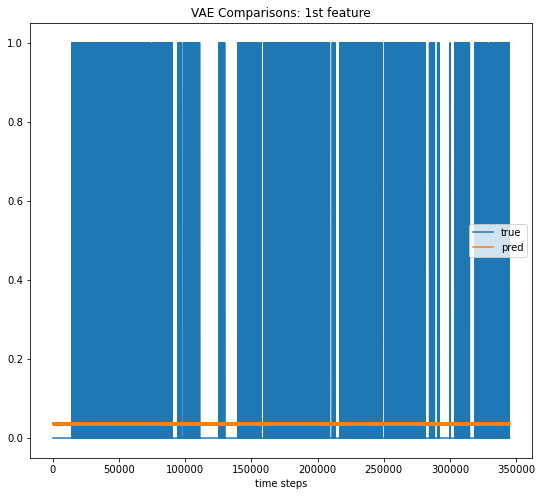

In [102]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 0], label = 'true')
plt.plot(predictions[:, 0], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 1st feature")
plt.show()

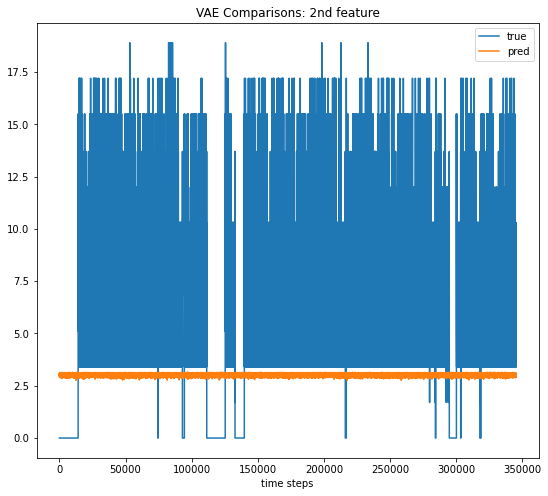

In [103]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 1], label = 'true')
plt.plot(predictions[:, 1], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 2nd feature")
plt.show()

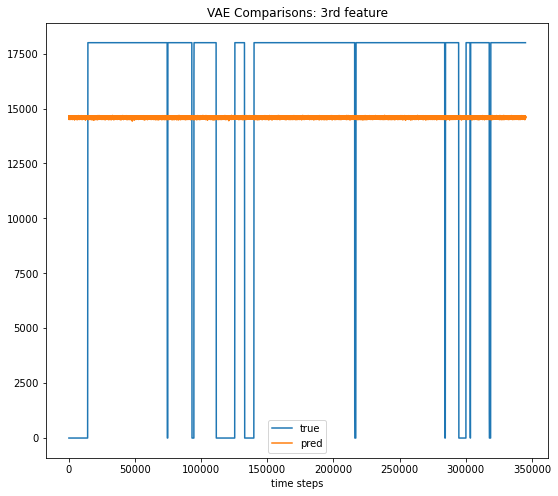

In [104]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 2], label = 'true')
plt.plot(predictions[:, 2], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 3rd feature")
plt.show()

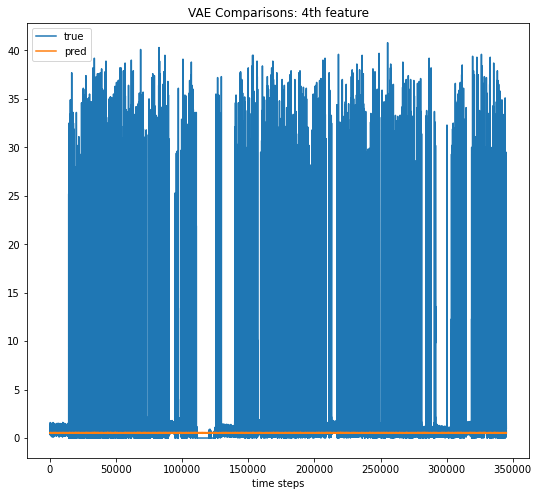

In [105]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 3], label = 'true')
plt.plot(predictions[:, 3], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 4th feature")
plt.show()

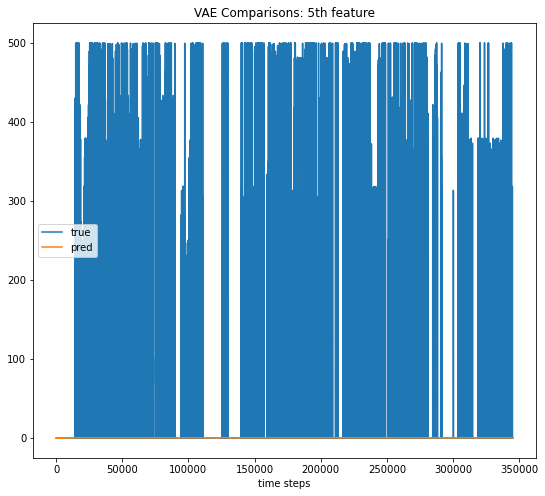

In [106]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 4], label = 'true')
plt.plot(predictions[:, 4], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 5th feature")
plt.show()

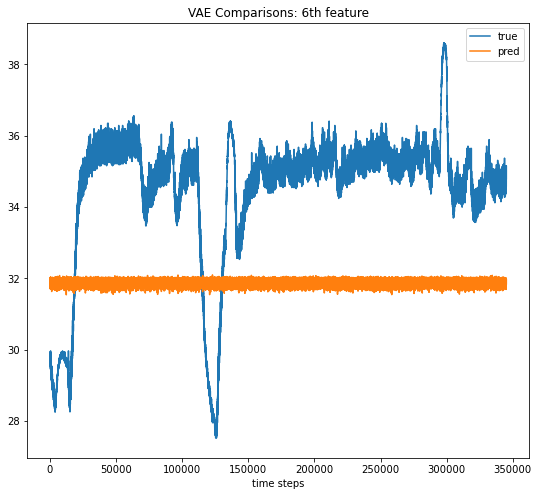

In [107]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 5], label = 'true')
plt.plot(predictions[:, 5], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 6th feature")
plt.show()

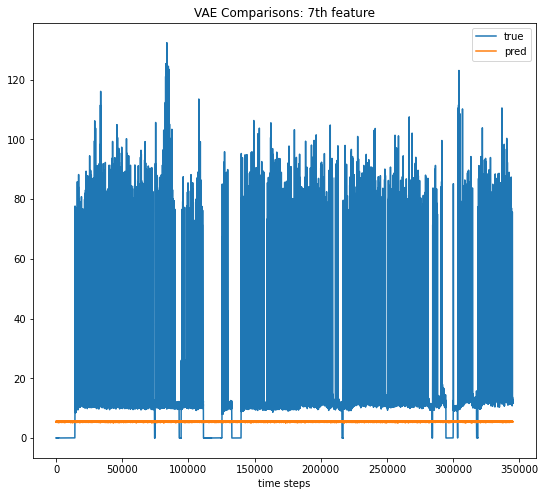

In [108]:
plt.figure(figsize = (9, 8))
plt.plot(true_vals[:, 6], label = 'true')
plt.plot(predictions[:, 6], label = 'pred')
plt.legend(loc = 'best')
plt.xlabel("time steps")
plt.title("VAE Comparisons: 7th feature")
plt.show()